# Lecture 7 Exercise

In this exercise, I will use PyTorch to implement a basic Recurrent Neural Network (RNN) and one of its variants, Long Short-Term Memory (LSTM), to solve a text classification task.

The [IMDb (Internet Movie Database)](https://huggingface.co/datasets/stanfordnlp/imdb) dataset contains movie reviews along with labels indicating whether the sentiment is positive or negative.

<div style="text-align: center;">Example of the Dataset</div>

| Review | Label |
|:--------:|:-------------:|
|Where's Michael Caine when you need him? I've ...|0|
|To experience Head you really need to understa...|1|

0 = negative, 1 = positive

I will input each review into the model and try binary classification of its label using an RNN.


## Table of Contents

 [Exercise: Implementation and Training of RNN and Derived Models](#scrollTo=kwLF7moq_PCZ&line=1&uniqifier=1)
1. [Loading the Dataset](#scrollTo=zEltPNkLuLz6)
2. [Training Execution (trainer) Function Definition](#scrollTo=G-laa4YqQRji)
3. Recurrent Neural Network (RNN) for sentiment analysis on IMDb

 3.1. [Embedding Layer](#scrollTo=Urh6GUOQKBzE)  

 3.2. [RNN](#scrollTo=ZNPaK9ExKBzI)  

 3.3. [Classifier](#scrollTo=2O0bZWqVOVk0)

 3.4. [Training](#scrollTo=emiO4f5rCklA)

 3.5. [Network Implementation Using torch.nn.RNN and torch.nn.Embedding](#scrollTo=yCktWJ9N8QDN)

4. Long Short-Term Memory (LSTM) for sentiment analysis on IMDb

 4.1. [LSTM](#scrollTo=tsXtYkNEm1Bh)

 4.2. [Classifier](#scrollTo=IfHaLvJJWHeI)

 4.3. [Training](#scrollTo=qR2iKUy7yA3R)

 4.4. [Network Implementation Using torch.nn.LSTM](#scrollTo=thf8W0lywagD)

5. Bidirectional LSTM

 5.1. [Bidirectional LSTM](#scrollTo=L9ZNn5gTP2yH)

 5.2. [Training](#scrollTo=1xbAI25fQA2E)

6. Supplement: [Handling Long Sequences with Gradient Clipping](#scrollTo=ExuiSiTo2k3m)


In [ ]:
!pip install portalocker
!pip install datasets

import random
import numpy as np
import string
import re
import string
from collections import Counter
from typing import List
import torch
import torch.nn as nn
import torch.optim as optim
import torch.autograd as autograd
from torch.utils.data import DataLoader,random_split
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_sequence
from sklearn.metrics import f1_score
from datasets import load_dataset
import nltk
from nltk.probability import FreqDist

nltk.download('punkt_tab')
seed = 1234
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)
random.seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

## Exercise: Implementation and Training of RNN and Its Variants


## 1. Loading the Dataset

In natural language processing, I cannot input raw text directly into the network, so I need to perform appropriate preprocessing.

The general preprocessing steps (for English text) are:
- I tokenize the text into words
- I assign an ID to each word

Through these steps, I convert the original sentence into a sequence of integers so that it can be input into the network.

In this exercise, I use a library called `NLTK` to assign IDs to each word.  
For more information, please refer to the [official documentation](https://www.nltk.org/api/nltk.html).


In [ ]:
# this function for avoiding nan caused by torch.log(0)
def torch_log(x):
    return torch.log(torch.clamp(x, min=1e-10))

In [ ]:
#  dataload
#  Even if you are prompted for a token, downloading the dataset does not require a HF (Hugging Face) token, so please click Cancel
print("Loading IMDB dataset...")
dataset = load_dataset("stanfordnlp/imdb")
#  split the data
train_data, valid_data = random_split(
    dataset['train'], [20000, 5000],
    )
test_data = dataset['test']

I use [nltk.probability.FreqDist](https://www.nltk.org/api/nltk.probability.html#nltk.probability.FreqDist) to count the words that appear in the training sentences and build a vocabulary list (as a `FreqDist` object).

I specify special tokens using the `specials` argument:
- `<unk>`: Unknown. I use this for words that appear too infrequently to be classified.
- `<PAD>`: I use this token to pad shorter sentences so that their lengths match longer ones.
- `<BOS>`: Begin of sentence.
- `<EOS>`: End of sentence.


In [ ]:
#  Separate words by spaces, remove symbols like !"#$%&, convert everything to lowercase, etc.
def tokenize(text):
    #  1. Convert to lowercase
    text = text.lower()

    #  2. Remove punctuation (string.punctuation)
    text = ''.join([char for char in text if char not in string.punctuation])

    #  3. Tokenize (split into words)
    tokens = text.split()
    return tokens


In [ ]:
#  Create a FreqDist object to record word frequencies
counter = FreqDist()
for i in range(len(train_data)):
    processed = tokenize(train_data[i]["text"])
    #  Add the tokenized word list to FreqDist and update frequencies
    counter.update(processed)

print(f"Vocabulary size: {len(counter)}")


In [ ]:
#  Set <unk> as the default, and replace words that appear fewer than min_freq times with <unk>
#  Apply min_freq and specials
min_freq = 25
specials = ['<unk>', '<PAD>', '<BOS>', '<EOS>']

vocab = specials + [word for word, freq in counter.items() if freq >= min_freq]
vocab_dict = {word: i for i, word in enumerate(vocab)}
word_num = len(vocab_dict)

print(f"Number of unique words: {word_num}")
print(list(vocab_dict))


Call `text_transform()` from within `collate_batch()` to convert a list of words into a list of indices based on the vocabulary dictionary.

In [ ]:
def text_transform(_text, max_length=256):
    #  If a token is not in vocab_dict, assign 0 = <unk>. Subtract 2 to account for <BOS> and <EOS> tokens.
    text = [vocab_dict.get(token, 0) for token in tokenize(_text)][:max_length - 2]
    text = [vocab_dict['<BOS>']] + text + [vocab_dict['<EOS>']]
    return text, len(text)

def collate_batch(batch):
   label_list, text_list, len_seq_list = [], [], []

   for data_point  in list(batch):
      _text = data_point.get('text')
      _label = data_point.get('label')
      label_list.append(_label)

      processed_text, len_seq = text_transform(_text)
      text_list.append(torch.tensor(processed_text))
      len_seq_list.append(len_seq)

   return torch.tensor(label_list), pad_sequence(text_list, padding_value=1).T, torch.tensor(len_seq_list)

By passing the `collate_batch()` function defined above to the `DataLoader`, I can apply that processing to each batch.

In [ ]:
batch_size = 128

train_dataloader = DataLoader(
   list(train_data),
   batch_size=batch_size,
   shuffle=True,
   collate_fn=collate_batch
)
valid_dataloader = DataLoader(
   list(valid_data),
   batch_size=batch_size,
   shuffle=False,
   collate_fn=collate_batch
)

## 2.Training Execution(trainer)Function Definition

Since the training loop will be the same for all models defined later, I will implement it here as a function.

In [ ]:
# NOTE: dataloader is in the global scope
def train(net, optimizer, n_epochs):
    for epoch in range(n_epochs):
        losses_train = []
        losses_valid = []

        net.train()
        n_train = 0
        acc_train = 0
        for label, line, len_seq in train_dataloader:
            net.zero_grad()  # Initialize gradients

            t = label.to(device)  # Move tensor to GPU
            x = line.to(device)   # (batch, time)
            len_seq.to(device)

            h = net(x, torch.max(len_seq), len_seq)
            y = torch.sigmoid(h).squeeze()

            loss = -torch.mean(t * torch_log(y) + (1 - t) * torch_log(1 - y)) 

            loss.backward()  # Backpropagation

            optimizer.step()  # Update parameters

            losses_train.append(loss.tolist())

            n_train += t.size()[0]

        # Validation
        t_valid = []
        y_pred = []
        net.eval()
        for label, line, len_seq in valid_dataloader:

            t = label.to(device)  # Move tensor to GPU
            x = line.to(device)
            len_seq.to(device)

            h = net(x, torch.max(len_seq), len_seq)
            y = torch.sigmoid(h).squeeze()

            loss = -torch.mean(t * torch_log(y) + (1 - t) * torch_log(1 - y))  

            pred = y.round().squeeze()  # Predict positive label for values >= 0.5

            t_valid.extend(t.tolist())
            y_pred.extend(pred.tolist())

            losses_valid.append(loss.tolist())

        print('EPOCH: {}, Train Loss: {:.3f}, Valid Loss: {:.3f}, Validation F1: {:.3f}'.format(
            epoch,
            np.mean(losses_train),
            np.mean(losses_valid),
            f1_score(t_valid, y_pred, average='macro')
        ))


## 3.Recurrent Neural Network (RNN) for sentiment analysis on IMDb

### 3.1. Embedding Layer

In the `Embedding` layer, I convert words from discrete IDs into continuous, high-dimensional vectors (called embeddings).

In the `Embedding` class below, the input $\boldsymbol{x}$ is a matrix where each row contains a sequence of word IDs for a sentence. The weight matrix $\boldsymbol{V}$ is a matrix where each row corresponds to the vector representation of a word ID.

The dimensions of each matrix are as follows:

- $\boldsymbol{x}$: (mini-batch size) × (maximum sequence length in the batch)  
- $\boldsymbol{V}$: (vocabulary size) × (embedding dimension)

By using $\boldsymbol{V}$ to look up the vector for each word ID in $\boldsymbol{x}$, I convert each word into its corresponding embedding vector.

As a result, the output tensor has the shape:  
(mini-batch size) × (maximum sequence length in the batch) × (embedding dimension)


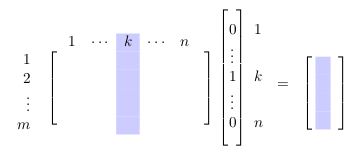

Let $m$: embedding dimension, and $n$: vocabulary size.



In [ ]:
class Embedding(nn.Module):
    def __init__(self, vocab_size, emb_dim):
        super().__init__()
        self.embedding_matrix = nn.Parameter(torch.randn((vocab_size, emb_dim),  #  Generates random numbers from a Gaussian (normal) distribution
                                                        dtype=torch.float))

    def forward(self, x):
        return F.embedding(x, self.embedding_matrix)

### 3.2. RNN

In the `RNN` class, I process the input obtained by converting each word into a vector using the Embedding layer. Here, the input $\boldsymbol{x}$ has the following dimensions:

- $\boldsymbol{x}$: (mini-batch size) × (maximum sequence length in the batch) × (embedding dimension)

I define the `RNN` class using `nn.Module`.


In [ ]:
class RNN(nn.Module):
    def __init__(self, in_dim, hid_dim):
        super().__init__()
        self.hid_dim = hid_dim
        glorot = 6 / (in_dim + hid_dim * 2)
        self.W = nn.Parameter(torch.tensor(np.random.uniform(
                        low=-np.sqrt(glorot),
                        high=np.sqrt(glorot),
                        size=(in_dim + hid_dim, hid_dim)
                    ).astype('float32')))
        self.b = nn.Parameter(torch.tensor(np.zeros([hid_dim]).astype('float32')))

    def function(self, h, x):
        return torch.tanh(torch.matmul(torch.cat([h, x], dim=1), self.W) + self.b)

    def forward(self, x, len_seq_max=0, init_state=None):
        x = x.transpose(0, 1)  # Transpose dimensions to (sequence, batch) for batch processing
        state = init_state

        if init_state is None:  # Initialize with zeros if no initial state is provided
            state = torch.zeros((x[0].size()[0], self.hid_dim)).to(x.device)

        size = list(state.unsqueeze(0).size())
        size[0] = 0
        output = torch.empty(size, dtype=torch.float).to(x.device)  # Create an empty tensor to accumulate outputs

        if len_seq_max == 0:
            len_seq_max = x.size(0)
        for i in range(len_seq_max):
            state = self.function(state, x[i])
            output = torch.cat([output, state.unsqueeze(0)])  # Append to output sequence
        return output


### 3.3. Classifier

In [ ]:
# RNN
class SequenceTaggingNet(nn.Module):
    def __init__(self, word_num, emb_dim, hid_dim):
        super().__init__()
        self.emb = Embedding(word_num, emb_dim)
        self.rnn = RNN(emb_dim, hid_dim)
        self.linear = nn.Linear(hid_dim, 1)

    def forward(self, x, len_seq_max=0, len_seq=None, init_state=None):
        h = self.emb(x)  
        h = self.rnn(h, len_seq_max, init_state)
        if len_seq is not None:
            # Since we need the output at the end of each sequence, aggregate using len_seq
            h = h[len_seq - 1, list(range(len(x))), :]
        else:
            h = h[-1]
        y = self.linear(h)
        return y


### 3.4. Training

In [ ]:
emb_dim = 100
hid_dim = 50
n_epochs = 10
device = 'cuda'

net = SequenceTaggingNet(word_num, emb_dim, hid_dim)
net.to(device)

optimizer = optim.Adam(net.parameters())

train(net, optimizer, n_epochs)

### 3.5. Network Implementation Using `torch.nn.RNN` and `torch.nn.Embedding`

Just like how `torch.nn.Conv2d` allows easy implementation of CNN layers, `torch.nn.RNN` makes it simple to implement RNN layers.

`torch.nn.RNN` takes a sequence input $x$ and an initial hidden state $h_0$ as arguments, and returns the output sequence $y$ and the final hidden state $h$ (`y, h = self.RNN(x, h_0)`).

However, one slightly tricky aspect is that `nn.RNN` expects the input sequence data in the shape [sequence length, batch size, feature dimension] by default. On the other hand, data provided by the DataLoader is typically in the shape [batch size, sequence length, feature dimension], which is often considered more intuitive. 

To handle this, `torch.nn.RNN` accepts a `batch_first` argument. By setting `batch_first=True`, the input sequence can be passed in the [batch size, sequence length, feature dimension] format.

Note that when `batch_first=True`, the output will also follow that format. If you need to extract outputs in the [sequence length, batch size, feature dimension] format (e.g., to align with `len_seq`), you can use `transpose` accordingly.

Additionally, `torch.nn.RNN` has a `num_layers` argument that specifies the number of stacked RNN layers. While stacking multiple layers is possible, we use a single layer here for consistency with the implementation in Task 2.

Similarly, `torch.nn.Embedding` makes it easy to implement the embedding layer.


In [ ]:
# nn.RNN
class SequenceTaggingNet2(nn.Module):
    def __init__(self, word_num, emb_dim, hid_dim):
        super().__init__()
        self.emb = nn.Embedding(word_num, emb_dim)  # Use nn.Embedding
        self.rnn = nn.RNN(emb_dim, hid_dim, 1, batch_first=True)  # Use nn.RNN
        self.linear = nn.Linear(hid_dim, 1)

    def forward(self, x, len_seq_max=0, len_seq=None, init_state=None):
        h = self.emb(x)
        if len_seq_max > 0:
            h, _ = self.rnn(h[:, 0:len_seq_max, :], init_state)
        else:
            h, _ = self.rnn(h, init_state)
        h = h.transpose(0, 1)
        if len_seq is not None:
            # Since we need the output at the end of each sequence, aggregate using len_seq
            h = h[len_seq - 1, list(range(len(x))), :]
        else:
            h = h[-1]

        y = self.linear(h)

        return y


In [ ]:
emb_dim = 100
hid_dim = 50
n_epochs = 10
device = 'cuda'

net = SequenceTaggingNet2(word_num, emb_dim, hid_dim)
net.to(device)

optimizer = optim.Adam(net.parameters())

train(net, optimizer, n_epochs)

## 4.Long short-term memory (LSTM)

### 4.1. LSTM

The LSTM implementation follows the equations below. (Here, $\odot$ denotes element-wise multiplication):

- Input gate: $\hspace{20mm}\boldsymbol{i}_t = \sigma \left(\boldsymbol{W}_i \left[\begin{array}{c} \boldsymbol{x}_t \\ \boldsymbol{h}_{t-1} \end{array}\right] + \boldsymbol{b}_i\right)$  
- Forget gate: $\hspace{20mm}\boldsymbol{f}_t = \sigma \left(\boldsymbol{W}_f \left[\begin{array}{c} \boldsymbol{x}_t \\ \boldsymbol{h}_{t-1} \end{array}\right] + \boldsymbol{b}_f\right)$  
- Output gate: $\hspace{20mm}\boldsymbol{o}_t = \sigma \left(\boldsymbol{W}_o \left[\begin{array}{c} \boldsymbol{x}_t \\ \boldsymbol{h}_{t-1} \end{array}\right] + \boldsymbol{b}_o\right)$  
- Cell state: $\hspace{20mm}\boldsymbol{c}_t = \boldsymbol{f}_t \odot \boldsymbol{c}_{t-1} + \boldsymbol{i}_t \odot \tanh \left(\boldsymbol{W}_c \left[\begin{array}{c} \boldsymbol{x}_t \\ \boldsymbol{h}_{t-1} \end{array}\right] + \boldsymbol{b}_c\right)$  
- Hidden state: $\hspace{20mm}\boldsymbol{h}_t = \boldsymbol{o}_t \odot \tanh \left(\boldsymbol{c}_t \right)$

Note that in a simple RNN, each step returns only the hidden state ($\boldsymbol{h}_t$), whereas in an LSTM, both the cell state and the hidden state ($\boldsymbol{c}_t$, $\boldsymbol{h}_t$) are returned.


In [ ]:
class LSTM(nn.Module):
    def __init__(self, in_dim, hid_dim):
        super().__init__()
        self.hid_dim = hid_dim
        glorot = 6 / (in_dim + hid_dim * 2)

        self.W_i = nn.Parameter(torch.tensor(np.random.uniform(
            low=-np.sqrt(glorot),
            high=np.sqrt(glorot),
            size=(in_dim + hid_dim, hid_dim)
        ).astype('float32')))
        self.b_i = nn.Parameter(torch.tensor(np.zeros([hid_dim]).astype('float32')))

        self.W_f = nn.Parameter(torch.tensor(np.random.uniform(
            low=-np.sqrt(glorot),
            high=np.sqrt(glorot),
            size=(in_dim + hid_dim, hid_dim)
        ).astype('float32')))
        self.b_f = nn.Parameter(torch.tensor(np.zeros([hid_dim]).astype('float32')))

        self.W_o = nn.Parameter(torch.tensor(np.random.uniform(
            low=-np.sqrt(glorot),
            high=np.sqrt(glorot),
            size=(in_dim + hid_dim, hid_dim)
        ).astype('float32')))
        self.b_o = nn.Parameter(torch.tensor(np.zeros([hid_dim]).astype('float32')))

        self.W_c = nn.Parameter(torch.tensor(np.random.uniform(
            low=-np.sqrt(glorot),
            high=np.sqrt(glorot),
            size=(in_dim + hid_dim, hid_dim)
        ).astype('float32')))
        self.b_c = nn.Parameter(torch.tensor(np.zeros([hid_dim]).astype('float32')))

    def function(self, state_c, state_h, x):
        i = torch.sigmoid(torch.matmul(torch.cat([state_h, x], dim=1), self.W_i) + self.b_i)  # Input gate
        f = torch.sigmoid(torch.matmul(torch.cat([state_h, x], dim=1), self.W_f) + self.b_f)  # Forget gate
        o = torch.sigmoid(torch.matmul(torch.cat([state_h, x], dim=1), self.W_o) + self.b_o)  # Output gate
        c = f * state_c + i * torch.tanh(torch.matmul(torch.cat([state_h, x], dim=1), self.W_c) + self.b_c)  # Cell state
        h = o * torch.tanh(c)  # Hidden state
        return c, h

    def forward(self, x, len_seq_max=0, init_state_c=None, init_state_h=None):
        x = x.transpose(0, 1)  # Transpose dimensions to (sequence, batch) for batch processing
        state_c = init_state_c
        state_h = init_state_h
        if init_state_c is None:  # Initialize with zeros if no initial cell state is provided
            state_c = torch.zeros((x[0].size()[0], self.hid_dim)).to(x.device)
        if init_state_h is None:  # Initialize with zeros if no initial hidden state is provided
            state_h = torch.zeros((x[0].size()[0], self.hid_dim)).to(x.device)

        size = list(state_h.unsqueeze(0).size())
        size[0] = 0
        output = torch.empty(size, dtype=torch.float).to(x.device)  # Create an empty tensor to accumulate outputs

        if len_seq_max == 0:
            len_seq_max = x.size(0)
        for i in range(len_seq_max):
            state_c, state_h = self.function(state_c, state_h, x[i])
            output = torch.cat([output, state_h.unsqueeze(0)])  # Append hidden state to output sequence
        return output


### 4.2. Classifier

In [ ]:
#  LSTM
class SequenceTaggingNet3(nn.Module):
    def __init__(self, word_num, emb_dim, hid_dim):
        super().__init__()
        self.emb = Embedding(word_num, emb_dim)
        self.lstm = LSTM(emb_dim, hid_dim)
        self.linear = nn.Linear(hid_dim, 1)

    def forward(self, x, len_seq_max=0, len_seq=None, init_state=None):
        h = self.emb(x)  
        h = self.lstm(h, len_seq_max, init_state)  
        if len_seq is not None:
            # need to take the output at the end of the sequence and aggregate based on len_seq
            h = h[len_seq - 1, list(range(len(x))), :]
        else:
            h = h[-1]

        y = self.linear(h) 

        return y

### 4.3. Training

Compare the performance of RNNs and LSTMs on the same task.

In [ ]:
emb_dim = 100
hid_dim = 50
n_epochs = 5
device = 'cuda'

net = SequenceTaggingNet3(word_num, emb_dim, hid_dim)
net.to(device)
optimizer = optim.Adam(net.parameters())

train(net, optimizer, n_epochs)

### 4.4. `nn.LSTM`Network Implementation Using

LSTM can be implemented using `nn.LSTM` as well as RNN.

In [ ]:
#  nn.LSTM
class SequenceTaggingNet4(nn.Module):
    def __init__(self, word_num, emb_dim, hid_dim):
        super().__init__()
        self.emb = nn.Embedding(word_num, emb_dim)
        self.lstm = nn.LSTM(emb_dim, hid_dim, 1, batch_first=True)  #  nn.LSTM
        self.linear = nn.Linear(hid_dim, 1)

    def forward(self, x, len_seq_max=0, len_seq=None, init_state=None):
        h = self.emb(x)
        if len_seq_max > 0:
            h, _ = self.lstm(h[:, 0:len_seq_max, :], init_state)
        else:
            h, _ = self.lstm(h, init_state)
        h = h.transpose(0, 1)
        if len_seq is not None:
            h = h[len_seq - 1, list(range(len(x))), :]
        else:
            h = h[-1]
        y = self.linear(h)

        return y

In [ ]:
emb_dim = 100
hid_dim = 50
n_epochs = 10
device = 'cuda'

net = SequenceTaggingNet4(word_num, emb_dim, hid_dim)
net.to(device)
optimizer = optim.Adam(net.parameters())

train(net, optimizer, n_epochs)

## 5.BidirectionalLSTM

### 5.1. Bidirectional LSTM

In a Bidirectional LSTM, I prepare two separate LSTM networks: one that processes the sequence in the forward direction (`self.forward_lstm`), and another that processes it in the reverse direction (`self.backward_lstm`).  
The outputs from both directions are then concatenated and passed to a fully connected layer.  
While this increases the number of parameters, it allows the model to make predictions that take into account both past and future context.

Although this can be implemented simply by setting `bidirectional=True` in [nn.LSTM](https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html), I implement it manually here for the sake of understanding how it works.

- In this implementation, the `BidirectionalLSTM` class includes the classifier functionality that has previously been implemented in the `SequenceTaggingNet`. (Either approach is fine in practice.)


In [ ]:
class BidirectionalLSTM(nn.Module):
    def __init__(self, word_num, emb_dim, hid_dim):
        super().__init__()
        # Prepare LSTMs for forward and backward directions
        self.emb = nn.Embedding(word_num, emb_dim)
        self.forward_lstm = nn.LSTM(emb_dim, hid_dim, 1, batch_first=True)
        self.backward_lstm = nn.LSTM(emb_dim, hid_dim, 1, batch_first=True)
        self.linear = nn.Linear(hid_dim * 2, 1)  # Output from forward and backward LSTMs are concatenated

    def forward(self, x, len_seq_max=0, len_seq=None, init_state=None):
        h = self.emb(x)  # (batch_size, seq_length, emb_dim)

        # Reverse the sequence for the backward LSTM
        if len_seq_max > 0:
            h1, _ = self.forward_lstm(h[:, 0:len_seq_max, :], init_state)
            h2, _ = self.backward_lstm(torch.flip(h[:, 0:len_seq_max, :], dims=[1]), init_state)
        else:
            h1, _ = self.forward_lstm(h, init_state)  # (batch_size, seq_length, hid_dim)
            h2, _ = self.backward_lstm(torch.flip(h, dims=[1]), init_state)  # (batch_size, seq_length, hid_dim)

        # Flip the output of the backward LSTM back to the original order
        h2 = torch.flip(h2, dims=[1])

        # Concatenate the outputs of the forward and backward LSTMs
        h = torch.cat([h1, h2], dim=2).transpose(0, 1)

        if len_seq is not None:
            h = h[len_seq - 1, list(range(len(x))), :]
        else:
            h = h[-1]

        y = self.linear(h)

        return y


### 5.2. Training

Bidirectional LSTM performs the same task.

In [ ]:
emb_dim = 100
hid_dim = 50
n_epochs = 10
device = 'cuda'

net = BidirectionalLSTM(word_num, emb_dim, hid_dim)
net.to(device)
optimizer = optim.Adam(net.parameters())

train(net, optimizer, n_epochs)

## 6. Supplement: Handling Long Sequences with Gradient Clipping

While LSTMs are generally well-suited for training on long sequences, here I introduce **Gradient Clipping** as a technique for handling long sequences in standard RNNs.

In RNNs, the backpropagation algorithm is specifically referred to as **Back Propagation Through Time (BPTT)**, where gradients are multiplied not only across layers but also across time steps.

As a result, gradients are prone to becoming excessively large or small compared to standard backpropagation.

This phenomenon is known as the **exploding (or vanishing) gradient problem**. Exploding gradients, in particular, can destabilize training and make convergence difficult.

![Clipping](../figures/Clipping.png)  
Source: Ian Goodfellow et al., *Deep Learning*, MIT Press, 2016 (http://www.deeplearningbook.org/)

To address this, **Gradient Clipping** deliberately limits the magnitude of the gradients.

You can apply gradient clipping in PyTorch using the following function:

```python
torch.nn.utils.clip_grad_norm_(parameters, max_norm)


In [ ]:
def train_gradient_clipping(net, optimizer, n_epochs,
):
    for epoch in range(n_epochs):
        losses_train = []
        losses_valid = []

        net.train()
        n_train = 0
        acc_train = 0
        for label, line, len_seq in train_dataloader:

            net.zero_grad()

            t = label.to(device)  #  Move tensor to GPU
            x = line.to(device) #  ( batch, time )
            len_seq.to(device)

            h = net(x, torch.max(len_seq), len_seq)
            y = torch.sigmoid(h).squeeze()

            loss = -torch.mean(t*torch_log(y) + (1 - t)*torch_log(1 - y))

            loss.backward()

            #  Clipping the slope with an absolute value of 1.0
            torch.nn.utils.clip_grad_norm_(net.parameters(), 1.0)

            optimizer.step()

            losses_train.append(loss.tolist())

            n_train += t.size()[0]

        t_valid = []
        y_pred = []
        net.eval()
        for label, line, len_seq in valid_dataloader:

            t = label.to(device)  #  Move tensor to GPU
            x = line.to(device) #  ( batch, time )
            len_seq.to(device)

            h = net(x, torch.max(len_seq), len_seq)
            y = torch.sigmoid(h).squeeze()

            loss = -torch.mean(t*torch_log(y) + (1 - t)*torch_log(1 - y))

            pred = y.round().squeeze()

            t_valid.extend(t.tolist())
            y_pred.extend(pred.tolist())

            losses_valid.append(loss.tolist())

        print('EPOCH: {}, Train Loss: {:.3f}, Valid Loss: {:.3f}, Validation F1: {:.3f}'.format(
            epoch,
            np.mean(losses_train),
            np.mean(losses_valid),
            f1_score(t_valid, y_pred, average='macro')
        ))

In [ ]:
emb_dim = 100
hid_dim = 50
n_epochs = 10
device = 'cuda'

net = SequenceTaggingNet2(word_num, emb_dim, hid_dim)
net.to(device)
optimizer = optim.Adam(net.parameters())

train_gradient_clipping(net, optimizer, n_epochs)